In [1]:
import os
import yaml
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt.vocs import VOCS
from xopt.generators.bayesian.models.standard import StandardModelConstructor

from botorch.models.transforms import Normalize

# Read Data from File

In [2]:
with open("./data/exploration_2_nd_filter.yml", "r") as file:
    f = yaml.safe_load(file)

list(f.keys())

['data', 'evaluator', 'generator', 'vocs', 'xopt']

In [3]:
data = pd.DataFrame(f["data"])
data = data.dropna(subset=["total_rms_size"])
data

,13ARV1:Cx,13ARV1:Cx_std,13ARV1:Cy,13ARV1:Cy_std,13ARV1:Sx,13ARV1:Sx_std,13ARV1:Sy,13ARV1:Sy_std,13ARV1:image1:ArraySize0_RBV,13ARV1:image1:ArraySize0_RBV_std,...,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,AWAVXI11ICT:Ch1_std,total_rms_size,xopt_error,xopt_runtime
1,366.741006,1.042786,275.659871,1.078548,49.173776,2.934228,28.826575,1.814375,1920.0,0.0,...,0.000000,5.900000,550.000000,190.000000,246.000000,1.000000e-09,1.000000e-10,57.000278,False,6.519966
100,397.269688,0.930661,326.124423,0.367013,37.662779,1.367888,36.723681,1.425068,1920.0,0.0,...,-0.205224,5.648132,515.167227,201.626571,244.592257,1.000000e-09,0.000000e+00,52.603362,False,9.304709
101,359.242144,0.212839,257.678494,0.867668,8.290947,0.108205,25.447795,0.211115,1920.0,0.0,...,0.666339,5.740590,534.700417,238.097827,245.257044,1.000000e-09,0.000000e+00,26.764343,False,6.672761
102,359.765084,2.554813,359.018039,1.354696,43.836924,1.588441,42.266556,1.805961,1920.0,0.0,...,-0.563728,5.651622,524.219058,240.648635,251.057976,1.000000e-09,1.000000e-10,60.894480,False,6.924069
106,324.197813,0.523856,335.574353,0.949796,34.920597,1.728933,47.167652,1.047655,1920.0,0.0,...,0.764509,5.786961,540.821016,197.484758,240.502847,9.000000e-10,0.000000e+00,58.687609,False,6.583808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,337.967892,0.743451,276.208745,0.630784,52.631656,3.672034,18.919987,0.507614,1920.0,0.0,...,0.705238,5.710605,527.601589,190.311911,242.685500,1.000000e-09,1.000000e-10,55.929036,False,7.322226
95,394.958529,0.172805,239.069574,1.679936,20.761687,1.172962,47.331698,0.880327,1920.0,0.0,...,-0.994766,5.900000,528.145039,227.040163,245.987823,1.000000e-09,0.000000e+00,51.684981,False,7.642713
96,382.097382,0.572137,274.744801,0.344905,17.439046,0.553518,26.623301,0.585640,1920.0,0.0,...,-0.286727,5.891773,517.551701,210.516413,250.186544,1.000000e-09,0.000000e+00,31.826412,False,8.120944
97,428.387399,1.581714,321.724206,0.578667,48.482945,1.757416,35.662887,1.220338,1920.0,0.0,...,-0.212013,5.825667,522.306932,205.635963,243.559406,1.000000e-09,1.000000e-10,60.186688,False,8.486660


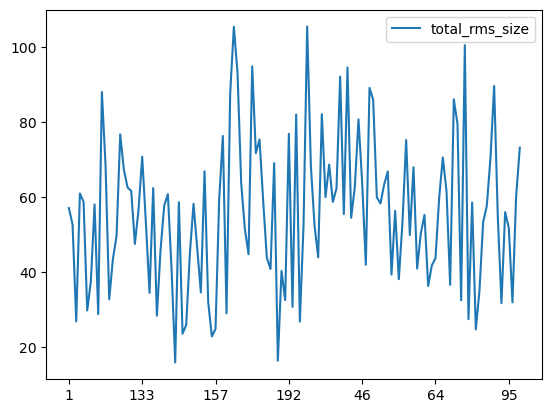

In [4]:
data.plot(y="total_rms_size");

In [5]:
vocs = VOCS(**f["vocs"])
vocs

VOCS(variables={'AWA:Bira3Ctrl:Ch03': [-5.0, 5.0], 'AWA:Bira3Ctrl:Ch04': [-5.0, 5.0], 'AWA:Bira3Ctrl:Ch05': [-5.0, 5.0], 'AWA:Bira3Ctrl:Ch06': [-5.0, 5.0], 'AWA:DAC0:Ch08': [4.5, 5.9], 'AWA:Drive:DS1:Ctrl': [500.0, 550.0], 'AWA:Drive:DS3:Ctrl': [180.0, 260.0], 'AWALLRF:K1:SetPhase': [236.0, 256.0]}, constraints={'13ARV1:penalty': ['LESS_THAN', 0.0]}, objectives={'total_rms_size': 'MINIMIZE'}, constants={})

In [6]:
# prepare output directory
output_dir = "./models/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Build GP Model and Generate Training Data

In [7]:
x_dim = len(vocs.variables)
x_lim = torch.tensor(vocs.bounds).T
y_dim = 1
y_lim = torch.tensor([[np.min(data[vocs.objective_names[0]].values), 
                       np.max(data[vocs.objective_names[0]].values)]])
print("y_lim:", y_lim)

y_lim: tensor([[ 15.7905, 105.4643]], dtype=torch.float64)


In [8]:
model_constructor = StandardModelConstructor()
gp = model_constructor.build_model_from_vocs(vocs, data).models[0]
gp

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): Normalize()
)

In [9]:
test_x = np.array(list(vocs.random_inputs(1).values())).flatten()
test_x = torch.from_numpy(test_x)
gp.posterior(test_x).mean

tensor([[53.4923]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

In [10]:
# get training data from measured data
x_meas = torch.from_numpy(data[vocs.variable_names].to_numpy())
y_meas = torch.from_numpy(data[vocs.objective_names[0]].to_numpy()).unsqueeze(-1)
x_meas.shape, y_meas.shape

(torch.Size([124, 8]), torch.Size([124, 1]))

In [11]:
# augment training data with GP posterior samples
n_aug = 1 * y_meas.shape[0]
x_aug = vocs.random_inputs(n_aug)
x_aug = torch.from_numpy(pd.DataFrame(x_aug)[vocs.variable_names].to_numpy())
y_aug = gp.posterior(x_aug).mean.detach()
x_aug.shape, y_aug.shape

(torch.Size([124, 8]), torch.Size([124, 1]))

In [12]:
# # generate grid data
# n_pts = 3  # points per grid dimension
# x_i = [torch.linspace(*x_lim[i], n_pts) for i in range(len(x_lim))]
# x = torch.cartesian_prod(*x_i)
# print(x.shape)

In [13]:
x = torch.cat([x_meas, x_aug])
y = torch.cat([y_meas, y_aug])
# x, y = x_meas, y_meas
x.shape, y.shape

(torch.Size([248, 8]), torch.Size([248, 1]))

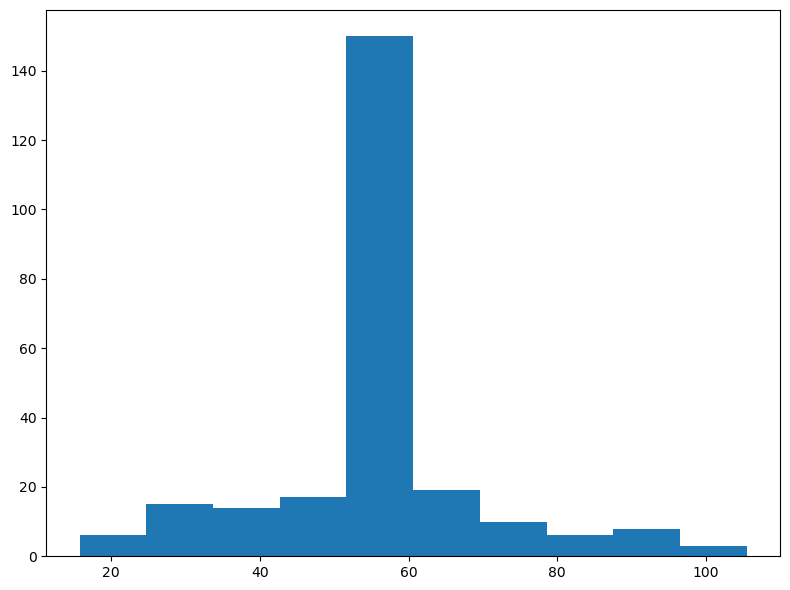

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.hist(y.squeeze().numpy(), bins=10)
fig.tight_layout()

In [15]:
# define train/test data
train_frac = 0.8
idx = torch.randperm(x.shape[0])
x, y = x[idx].double(), y[idx].double()
idx_split = int(train_frac * x.shape[0])
x_train, y_train = x[:idx_split], y[:idx_split]
x_test, y_test = x[idx_split:], y[idx_split:]

# save training and test data
torch.save({"x": x_train, "y": y_train}, output_dir + "train_data.pt")
torch.save({"x": x_test, "y": y_test}, output_dir + "test_data.pt")

# Prepare Training

In [16]:
# define in- and output transformers
x_transformer = Normalize(x_dim, bounds=x_lim.T)
y_transformer = Normalize(y_dim, bounds=y_lim.T)
torch.save(x_transformer.state_dict(), output_dir + "x_transformer.pt")
torch.save(y_transformer.state_dict(), output_dir + "y_transformer.pt")

In [17]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [18]:
def create_model():
    model = nn.Sequential(
        nn.Linear(8, 16),
        nn.Tanh(),
        nn.Dropout(p=0.05),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Dropout(p=0.05),
        nn.Linear(16, 8),
        nn.Tanh(),
        nn.Linear(8, 1)
    )
    return model.double()

In [19]:
class TransformedModel(nn.Module):
    def __init__(self, model, x_transformer, y_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
    
    def forward(self, x):
        x = self.x_transformer(x)
        x = self.model(x)
        x = self.y_transformer.untransform(x)
        return x

In [20]:
# define dataloaders
pin_memory = True
batch_size = y.shape[0]
trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=pin_memory)
testset = Dataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, 
                                         num_workers=0, pin_memory=pin_memory)

# Train Surrogate Models

In [21]:
lr = 1e-3
n_epochs = int(1e5)
model = TransformedModel(create_model(), x_transformer, y_transformer)
optimizer = optim.Adam(model.parameters(), lr=lr)  # , weight_decay=3e-6

In [22]:
# define loss function
class CustomLoss(nn.MSELoss):
    def __init__(self, penalty: float = 1.0, size_average=None, reduce=None,
                 reduction: str = 'mean') -> None:
        """Customized MSELoss which penalized negative predictions.

        Args:
            size_average: Inherited from torch.nn.MSELoss().
            reduce: Inherited from torch.nn.MSELoss().
            reduction: Inherited from torch.nn.MSELoss().
        """
        super(CustomLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        mask = x < 0.0
        delta = x - y
        delta_sum = torch.sum(delta[~mask] ** 2)
        delta_sum += torch.sum(delta[mask] ** 4)
        return delta_sum / y.shape[0]

    
#         return F.mse_loss(x, y, reduction=self.reduction)

    
#         mask = tar > threshold
#         if torch.all(tar <= threshold):
#             return F.mse_loss(0 * inp, 0 * tar, reduction=self.reduction)
#         if self.standardized_loss:
#             inp_eval = standardize(inp, dim=(-2, -1), keepdim=True)[mask]
#             tar_eval = standardize(tar, dim=(-2, -1), keepdim=True)[mask]
#         else:
#             inp_eval, tar_eval = inp[mask], tar[mask]
#         return F.mse_loss(inp_eval, tar_eval, reduction=self.reduction)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# criterion = CustomLoss()

In [23]:
# train model
train_losses = []
test_losses = []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "TEST_LOSS", "ETA"))
t0 = time.time()
best_loss = 1.0
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
#         # save model to file
#         if i == 0:
#             torch.save(model, output_dir + "{:d}ep.pt".format(epoch))

        inputs, labels = batch_data
        optimizer.zero_grad()
        model.train()
        outputs = model(inputs)
#         if epoch == 0 or epoch == n_epochs - 1:
#             print(model.y_transformer(outputs).shape, model.y_transformer(labels).shape)
#             print(model.y_transformer(outputs)[:10], model.y_transformer(labels)[:10])
        loss = criterion(model.y_transformer(outputs), model.y_transformer(labels))
        loss.backward()
        optimizer.step()

        if i == 0:
            model.eval()
            inputs_test, targets_test = next(iter(testloader))
            outputs_test = model(inputs_test)
            test_loss = criterion(model.y_transformer(outputs_test), model.y_transformer(targets_test))

            # store losses
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            
            if epoch % (n_epochs // 10) == 0:
                # save model to file
                if i == 0:
                    torch.save(model, output_dir + "{:d}ep.pt".format(epoch))
                
                # print info
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, test_loss, t_info)
                if test_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'
                print(info)
                if test_loss < best_loss:
                    best_loss = test_loss

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)                
print("Total runtime: {}".format(t_info))

# # save final model to file
# torch.save(model, output_dir + "{:d}ep.pt".format(n_epochs))

EPOCH      TRAIN_LOSS    TEST_LOSS          ETA
0             0.30317      0.32982     6.15 min
10000         0.07964      0.07983     1.61 min
20000         0.07167      0.09413     1.43 min
30000         0.06339      0.10999     1.26 min
40000         0.05717      0.11447     1.08 min
50000         0.05317      0.12584    54.03 sec
60000         0.05390      0.12739    43.17 sec
70000         0.05521      0.12448    32.39 sec
80000         0.04872      0.11649    21.65 sec
90000         0.04485      0.11653    10.84 sec
Total runtime: 1.81 min


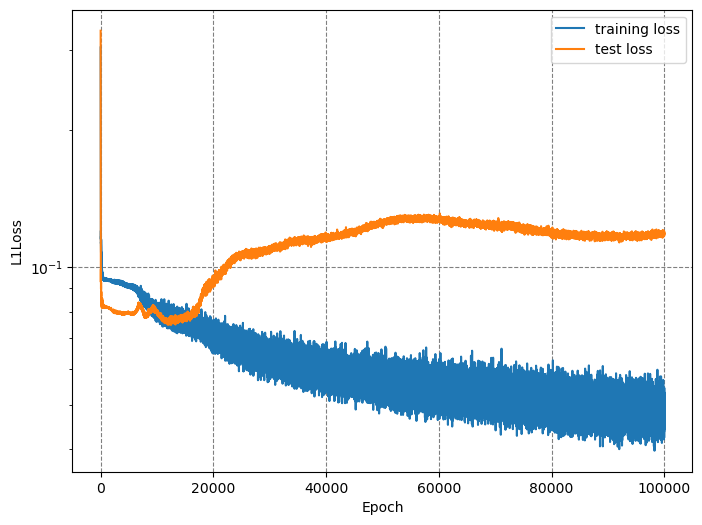

In [24]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(test_losses, c="C1", label="test loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")

In [25]:
idx = np.argmin(data[vocs.objective_names[0]].values)
ref_pt = data[vocs.variable_names].iloc[idx].values

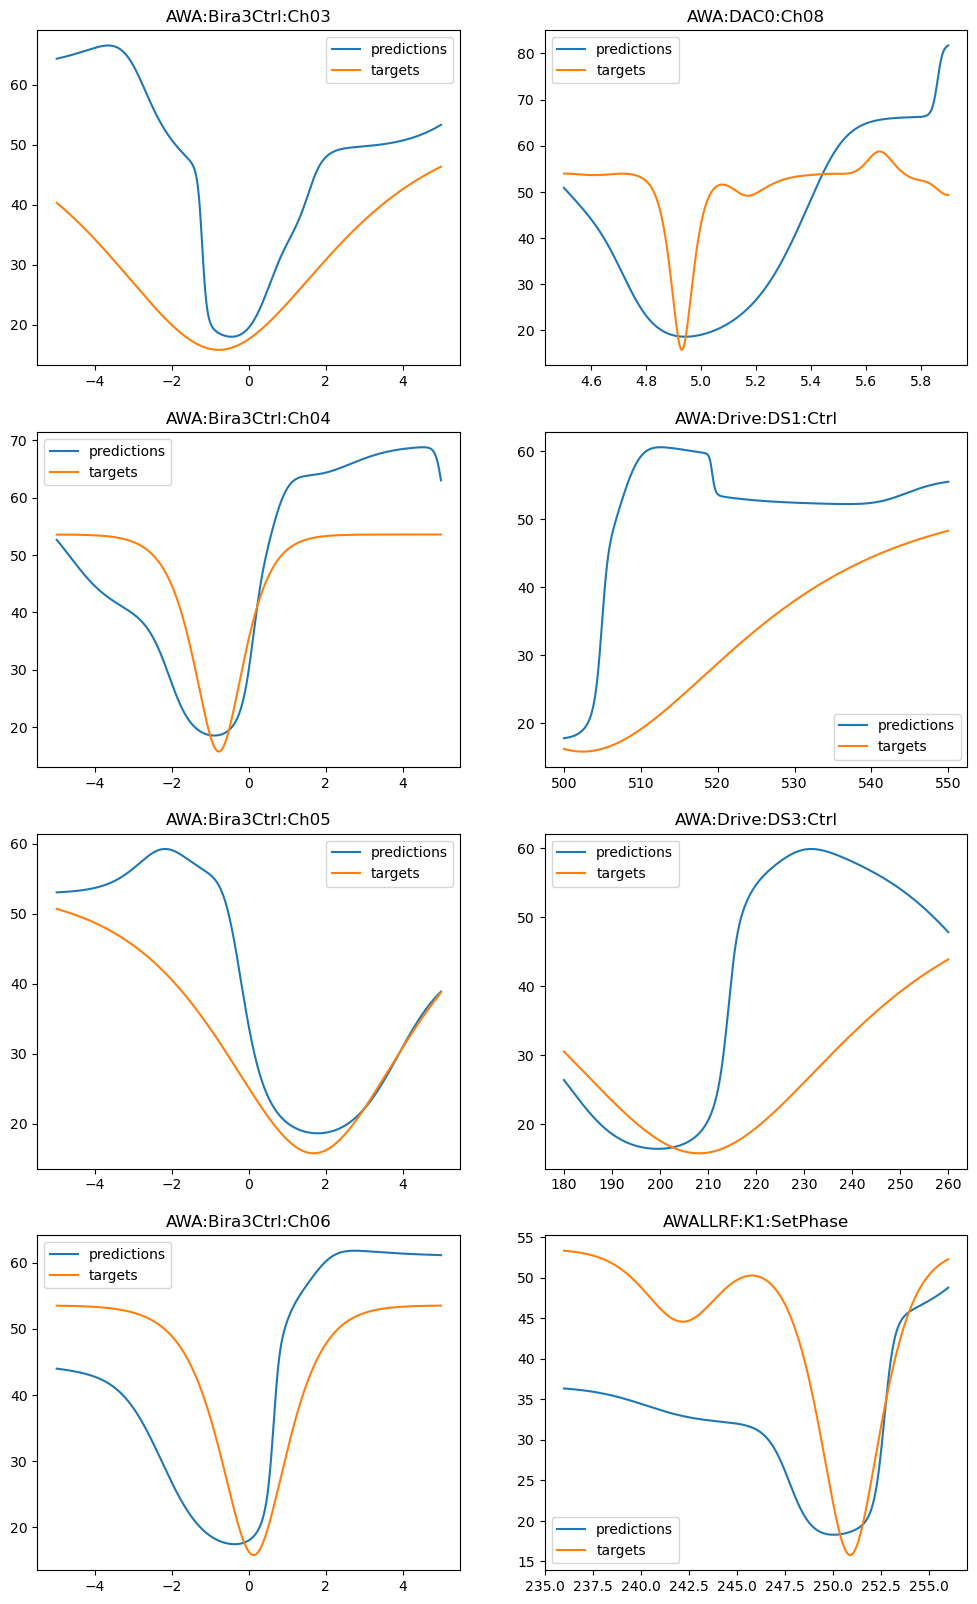

In [26]:
n = 1000
model.eval()
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(12, 20))
for i, name in enumerate(vocs.variable_names):
    # get data
    axis = torch.linspace(*vocs.variables[name], n)
    d = torch.from_numpy(ref_pt).unsqueeze(0).repeat([n, 1])
    d[:, i] = axis    
    pred = model(d)
    targets = gp.posterior(d).mean
    # plot
    ax_i = ax[i % 4, i // 4]
    ax_i.set_title(name)
    ax_i.plot(axis, pred.detach(), label="predictions")
    ax_i.plot(axis, targets.detach(), label="targets")
    ax_i.legend()

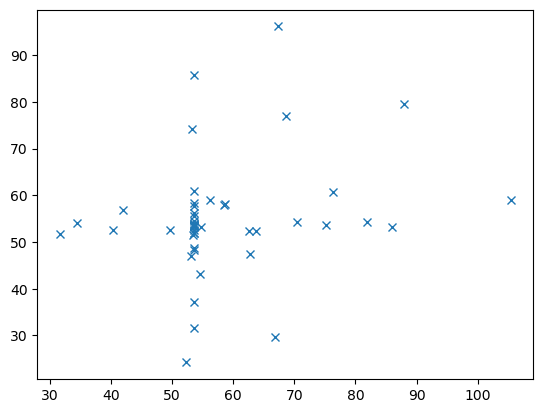

In [27]:
pred_test = model(x_test)
plt.plot(y_test, pred_test.detach(), "x")

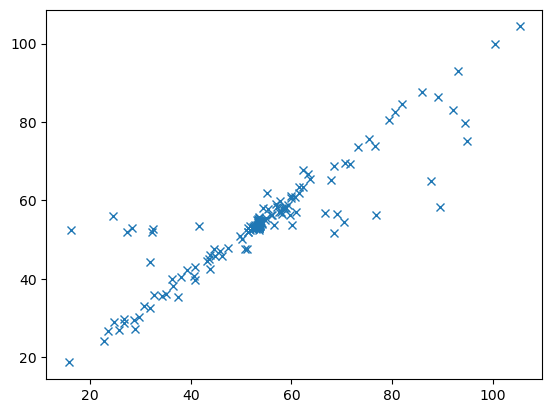

In [28]:
pred_train = model(x_train)
plt.plot(y_train, pred_train.detach(), "x")

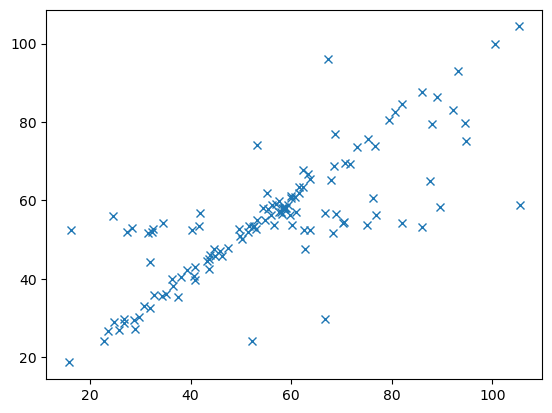

In [29]:
pred_meas = model(x_meas)
plt.plot(y_meas, pred_meas.detach(), "x")